# El reto de la matriz de varianzas covarianzas

La aplicación práctica de la técnica de optimización propuesta plantea muchos problemas.Vermos cuales son los retos principales.
La optimización de la cartera requiere la inversión de una matriz de covarianza, pero en la práctica esta matriz de covarianza no suele ser de rango completo. Si esto no se maneja adecuadamente, puede dar lugar a resultados inestables e indeseables al realizar la operación de inversión.Esto es especialmente difícil cuando se optimizan activos muy correlacionados, y puede dar lugar a carteras inestables e inverosímiles.

## Estimación del error en las rentabilidades esperadas

El error que cometemos cuando utilizamos datos históricos para estimar la rentabilidad esparada es:
$$\epsilon_{\mu}=\frac{\sigma}{\sqrt{T}} \tag{1}$$

donde $\epsilon_{\mu}$ es el error en la estimación, $\sigma$ es la volatilidad del activo y $T$ es la amplitud temporal utilizada para estimar la esperanza.

Si disponemos de 20 años de datos, y estimamos la media de un activo con una volatilidad del 20%, el error de estimación de la media es de casi el 4,5%. 

In [3]:
def emu(sigma, T):
   emu=sigma/(T)**0.5
   return emu

In [5]:
sigma=0.2
T=20
emu(sigma,T)

0.044721359549995794

Que ocurre si trabajamos con datos mensuales.

In [7]:
sigma_m= 0.2/(12)**0.5
T_m=20*12
emu(sigma_m,T_m)


0.00372677996249965

Vamos a visualizar el impacto que tiene en las fronteras eficientes el error en la estimación de la media.

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy as scipy
from datetime import datetime

stocks_list = 'XLB XLF XLK XLP XLV' 
start_date = '2017-09-01'
end_date = '2022-12-01'

df_price = yf.download(tickers=stocks_list, start=start_date,
                   end=end_date, interval="1d")['Adj Close'].dropna()
df_ret = np.log(df_price).diff().dropna()
ret = np.array(df_ret.mean()*252)  # convert to annualized return
cov_mat = np.array(df_ret.cov()*252)  # convert to annualized covariance

[*********************100%***********************]  5 of 5 completed


In [28]:
def efficient_frontier(ret, cov_mat, N=5000):

    assert len(ret)==len(cov_mat), 'Asegurate que el número de activos utilizados para calcular \
    la rentabilidad coincide con el utilizado para esimar la matriz de varianza-covarianza.'

    # Estimamos las constantes
    n = len(ret)
    a = np.ones(n).T@np.linalg.inv(cov_mat)@ret
    b = ret.T@np.linalg.inv(cov_mat)@ret
    c = np.ones(n).T@np.linalg.inv(cov_mat)@np.ones(n)
    d = b*c-a**2

    # generamos 5000 carteras eficientes 
    ret_arr = np.linspace(0.05,0.2,N)
    vol_arr = np.zeros(N)
    weight_arr = np.zeros((N, len(ret)))
    
    for i in range(N):
        w = 1/d*(c*np.linalg.inv(cov_mat)@ret-a*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d*(b*np.linalg.inv(cov_mat)@np.ones(n)-a*np.linalg.inv(cov_mat)@ret)
        vol_arr[i] = np.sqrt(w.T@cov_mat@w)
        weight_arr[i,:] = w

    
    return weight_arr, ret_arr, vol_arr

In [ ]:
# Fechas en formato de texto
start_date_str = '2017-09-01'
end_date_str = '2022-12-01'

# Convertir a objetos de fecha
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

# Calcular la diferencia en meses
diff_months = (end_date.year - start_date.year) * 12 + end_date.month - start_date.month
diff_months

Consideramos que la rentabilidad de los activos se comporta como una normal, por tanto representamos la frontera eficiente para la rentabilidad media, como para el limite inferior (ci_lower) y superior (ci_upper) del intervalo de confianza de la rentabilidad para nivel de confianza del 90%. Para ello utilizamos `scipy.stats.norm.interval(0.9, loc=ret, scale=sigma_ret)`:

- `scipy.stats.norm`: Se refiere a la distribución normal.
- `interval`: Esta función calcula los límites del intervalo de confianza para la distribución normal.
- `0.9`: Este es el nivel de confianza. En este caso, es del 90%, lo que significa que se espera que el 90% de los valores de la distribución se encuentren dentro de este intervalo.
- `loc=ret`: Este es el parámetro de ubicación (media) de la distribución normal. En estadísticas, loc generalmente se refiere a la media de la distribución. Aquí, ret representaría la rentabilidad esperada o media estimada de una inversión o activo.
- `scale=sigma_ret`: Este es el parámetro de escala (desviación estándar) de la distribución normal. En estadísticas, scale generalmente se refiere a la desviación estándar de la distribución. Aquí, sigma_ret representaría la volatilidad o desviación estándar de la rentabilidad del activo.
ci_lower, ci_upper = ...: La función devuelve dos valores, que son los límites inferior y superior del intervalo de confianza. Estos se asignan a ci_lower (límite inferior del intervalo de confianza) y ci_upper (límite superior del intervalo de confianza), respectivamente.

En resumen, este código calcula el intervalo de confianza del 90% para una distribución normal con una media (ubicación) igual a ret y una desviación estándar (escala) igual a sigma_ret. Esto te dice que, basándote en la distribución normal, hay un 90% de probabilidad de que el verdadero valor de la media (en este caso, la rentabilidad del activo) esté entre ci_lower y ci_upper.

In [31]:
sigma_ret = np.sqrt(np.diag(cov_mat))/np.sqrt(252)
ci_lower, ci_upper = scipy.stats.norm.interval(0.9, loc=ret, scale=sigma_ret)

print(ci_lower, ci_upper)

[0.07200464 0.06566803 0.14348539 0.07398911 0.09976049] [0.12177707 0.12057197 0.20027962 0.1096156  0.13946061]


In [42]:
mean_weight_arr, mean_ret_arr, mean_vol_arr = efficient_frontier(ret, cov_mat )
cil_weight_arr,cil_ret_arr, cil_vol_arr = efficient_frontier(ci_lower, cov_mat )
ciu_weight_arr, ciu_ret_arr, ciu_vol_arr = efficient_frontier(ci_upper, cov_mat )

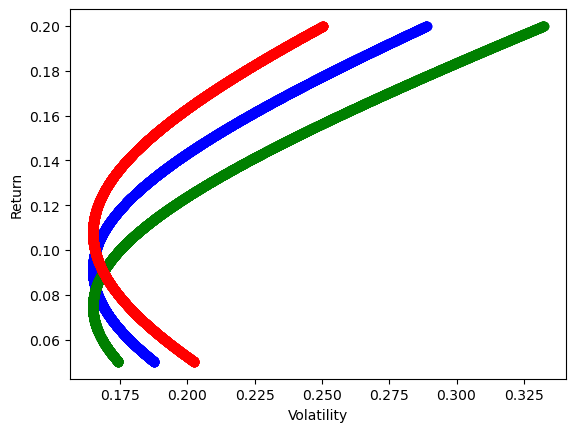

In [40]:
# plot the efficient frontier
plt.scatter(mean_vol_arr, mean_ret_arr, c='blue', label='Mean')
plt.scatter(cil_vol_arr, cil_ret_arr, c='green', label='CI Lower')
plt.scatter(ciu_vol_arr, ciu_ret_arr, c='red', label='CI Upper')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()
    

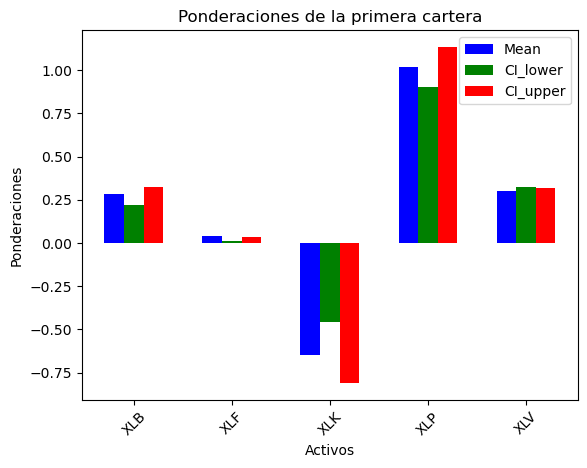

In [51]:
first_portfolio_weights_mean=mean_weight_arr[0]
first_portfolio_weights_cil=cil_weight_arr[0]
first_portfolio_weights_ciu=ciu_weight_arr[0]
stocks = stocks_list.split()

# Configuración del gráfico
bar_width = 0.2  # Ancho de las barras
index = np.arange(len(stocks))  # Los índices de las barras

plt.bar(index, first_portfolio_weights_mean,bar_width, label='Mean',color='blue')
plt.bar(index+ bar_width, first_portfolio_weights_cil,bar_width, label='CI_lower',color='green')
plt.bar(index+ 2*bar_width, first_portfolio_weights_ciu, bar_width, label='CI_upper',color='red')
plt.xlabel('Activos')
plt.ylabel('Ponderaciones')
plt.title('Ponderaciones de la primera cartera')
plt.xticks(rotation=45)  # Rota las etiquetas para mejor legibilidad si son muchas o largas
plt.xticks(index + bar_width, stocks)
plt.legend()
plt.show()

## Estimación del error en la varianza estimada

Lo, Campbell adn Mackinlay (1997) muestran que el error en la estimación de la varianza es:
$$\epsilon_{var}=2\left(\frac{T}{\bigtriangleup_t}-1\right)^{-1} \sigma^2 \tag{2}$$

donde $T$ es el número de periodos, $\bigtriangleup_t$ es la frecuencia en la que la varianza ha sido calculada. El incremento de la frecuencia en la obtención de los datos reduce el error en la estimación de la varianza.

HACER UN EJEMPLO

## Singularidad de las matrices de varianzas covarianzas

Si la matriz de covarianza no es de rango completo, es decir, es singular, entonces no será invertible. En finanzas es muy probable que ocurra debido a la estructura de los datos con los que trabajamos. Generalmente trabajamos con un gran número de activos y con historiales relativamente cortos. En este caso, si el número de activos, $N$, supera los periodos de tiempo históricos disponibles, $T$, la matriz de covarianza será singular por construcción. 

En términos más generales, para $N$ activos, necesitamos periodos de tiempo muy superiores a $N$ para tener una matriz de rango completo. En los casos en que la matriz sea singular, tendremos que recurrir a técnicas de pseudoinversión, que utilizarán técnicas como la descomposición de valores propios o de valores singulares para invertir la matriz de rango bajo de forma estable.

Aún más problemático es que la matriz de covarianza empírica tenga valores propios negativos. Los valores propios negativos no son algo que debería ocurrir de forma natural, ya que implica una varianza negativa para una cartera, lo que claramente no es sensato. Sin embargo, puede ocurrir en la práctica dependiendo de cómo se cree la matriz de covarianza. Por ejemplo, los valores propios negativos pueden ocurrir si utilizamos diferentes ventanas para el cálculo de diferentes términos de covarianza por pares. Si nos encontramos con valores propios negativos, debemos corregirlos antes de invertir la matriz de covarianza.

Por último, incluso en el caso de una matriz de covarianza con todos los valores propios positivos, la inversión de la matriz de covarianza puede dar lugar a propiedades no deseadas. Esencialmente, si no se hace con cuidado podemos estar amplificando el ruido al invertir la matriz de covarianza.

La descomposición de una matriz de covarianza en valores propios es la siguiente:
$$\Sigma=Q\Lambda Q^T\tag{3}$$

donde $\Lambda$ es una matriz diagonal de autovalores $\lambda_i$ en la diagonal. Además:
$$\Sigma^{-1}=Q\Lambda^{-1} Q^T\tag{4}$$

donde $\Lambda^{-1}$ es la inversa de la $\Lambda$ y los elementos de la diagonal son $\Lambda_{ii}^{-1}=\frac{1}{\lambda_i}$. 

Esto tiene importantes implicaciones para la construcción de carteras eficientes. Es importante recordar que  los valores propios más pequeños adquieren el mayor cuando estimamos la inversa. Esto es problemático porque lo más probable es que los valores propios más pequeños sean ruido. Además, son los valores propios que son estadísticamente indistinguibles de cero en muchos casos. Sin embargo, cuando optimizamos amplificamos estos valores propios insignificantes para que tengan un impacto significativo en la solución. Por ello, se recomienda que, cuando se trabaje con matrices de covarianza en la práctica y se estimen la matriz inversa, los valores propios pequeños se sustituyan por cero y la matriz de bajo rango resultante se trate mediante una operación pseudoinversa, como se ha comentado anteriormente. 

In [52]:
def inverse_cov_mat(cov_mat, eps=1e-2, is_plot=True):
    
    w, v = np.linalg.eig(cov_mat)

    # step 1. check if eigenvalues are non-negative 
    assert np.where(w>=0, True, False).sum()==len(w), 'Please ensure the covariance matrix is positive semi-definite.'
    
    # step 2. calculate relative weights and drop small eigenvalues
    weighted_w = w/np.sum(w)
    if is_plot:
        plt.plot(np.sort(w)[::-1], marker='x', label='eigenvalue')
        plt.legend()
        plt.show()
        plt.bar(range(len(w)), np.sort(weighted_w)[::-1], width=0.3, label='relative weight')
        plt.legend()
        plt.show()
        
    w_hat = np.where(weighted_w>=eps, w, 0)
    noise_free_w = w_hat*(np.sum(w)/np.sum(w_hat))

    # step 3. calculate inverse matrix
    inv_mat = v@np.diag(np.where(noise_free_w!=0, 1/noise_free_w, 0))@v.T

    return w, noise_free_w, inv_mat

HACER UN EJEMPLO COMO EL QUE ESTÁ EN EL LIBRO

## La no estacionariedad de las correlaciones de los activos.

La estacionariedad en el contexto de las correlaciones se refiere a la propiedad de que las estadísticas de la serie temporal, como la media y la varianza, permanecen constantes a lo largo del tiempo. Cuando se dice que las correlaciones no son estacionarias, significa que las relaciones de correlación entre diferentes activos financieros cambian con el tiempo. Además las correlaciones tienden a ser más bajas en condiciones de equilibrio y luego se disparan en momentos de tensión en el mercado. 

Si la correlaciones son distintas para diferentes condiciones de mercado, entonces podríamos utilizar una correlación media para el periodo de tiempo completo. Chow, Jacquier y Lowry (1999) proponen la siguiente matriz de covarianza:

$$\Sigma=p\Sigma_s+(1-p) \Sigma_e$$

donde $\Sigma_s$ es la matriz de covarianzas en momentos de stress, $\Sigma_e$ es la matriz de covarianzas en momentos de equilibrio y $p$ e sla probabilidad de entrar en un momento de stress. $p$ puede ser estimada con datos históricos, pero también puede adaptarse a la aversión al riesgo del inversor. Aquellos que presetan una alta aversión al riesgo puede que utilicen altos valores de $p$ para construir su cartera. Podemos utiliza un algortimos de cluster para estimar  $\Sigma_s$ y $\Sigma_e$, para diferenciar los momentos de equilibrio  y de estres.



EJEMPLO EN EL CAPITULO 21